# CHALLENGE 2

##### IMPORTS

In [89]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

tfk = tf.keras
tfkl = tf.keras.layers
tf.get_logger().setLevel('ERROR')
print(tf.__version__)

2.20.0-rc0


In [90]:
import warnings
warnings.filterwarnings('ignore')

##### SEED DECLARATION

In [91]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

##### DATASET PATH

In [92]:
root = Path.cwd()

# Full dataset
dataset_dir = root / "../data/TrainingCH2.csv"

# Sample dataset
# dataset_dir = root / "../data/TrainingCH2_sample.csv"

print(dataset_dir)

C:\Users\Giacomo Da Re\git\Challenges\Challenge2\data\TrainingCH2.csv


In [93]:
dataset = pd.read_csv(dataset_dir)

##### VALIDATION SET

In [94]:
train_ratio = 0.8
split_idx = int(len(dataset) * train_ratio)

train_df = dataset.iloc[:split_idx].copy()
val_df   = dataset.iloc[split_idx:].copy()

In [95]:
# Min-Max per column on TRAIN; safe denominator for zero-range columns
X_min = train_df.min()
X_max = train_df.max()
denom = (X_max - X_min).replace(0, 1.0)

def scale_df(df: pd.DataFrame) -> pd.DataFrame:
    return (df - X_min) / denom

train_scaled = scale_df(train_df)
val_scaled   = scale_df(val_df)

##### SEQUENCE

In [96]:
def build_sequences(df: pd.DataFrame, target_labels: list[str] | None, window: int, stride: int, telescope: int):
    arr = df.values
    if target_labels is None:
        target_cols = list(df.columns)  # multivariate target = all columns
    else:
        target_cols = list(target_labels)
    y_arr = df[target_cols].values

    X_list, y_list = [], []
    last_start = len(df) - window - telescope
    if last_start < 0:
        return np.empty((0, window, df.shape[1])), np.empty((0, telescope, len(target_cols)))
    for start in range(0, last_start + 1, stride):
        X_list.append(arr[start : start + window])
        y_list.append(y_arr[start + window : start + window + telescope])
    return np.asarray(X_list), np.asarray(y_list)

target_labels = list(dataset.columns)  # multivariate forecasting (all columns)

In [97]:
target_labels = dataset.columns

telescope = 30 # number of data to predict
window = 80 # number of data where predict from
stride = 10 # window shift

X_train, y_train = build_sequences(
    train_scaled, target_labels, window=window, stride=stride, telescope=telescope
)
X_val, y_val = build_sequences(
    val_scaled, target_labels, window=window, stride=stride, telescope=telescope
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Val   shapes:", X_val.shape, y_val.shape)

Train shapes: (5472, 80, 7) (5472, 30, 7)
Val   shapes: (1360, 80, 7) (1360, 30, 7)


##### DATA TO PREDICT

In [98]:
future = val_df.iloc[-window:].copy()
future = (future - X_min) / denom
future = np.expand_dims(future.values, axis=0)

print("future shape:", future.shape)  # (1, window, n_features)

future shape: (1, 80, 7)


##### TASK VISUALIZATION

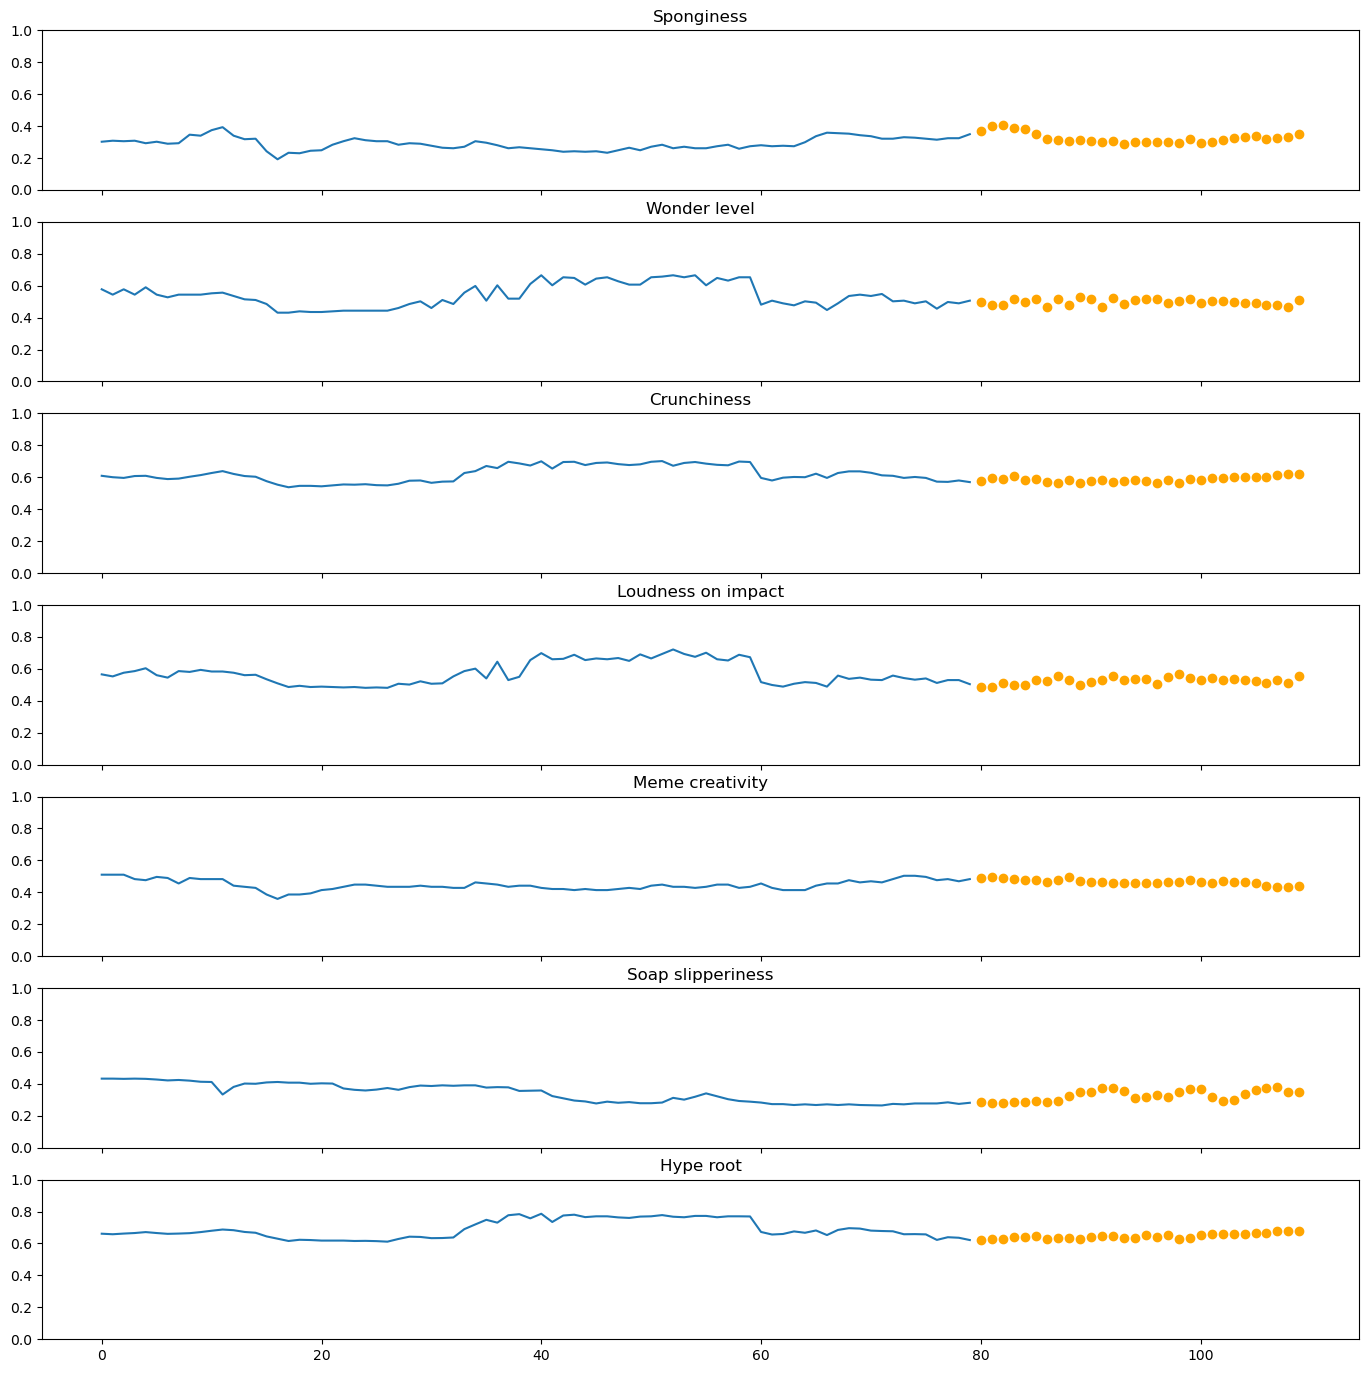

In [99]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))
        
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

inspect_multivariate(X_train, y_train, target_labels, telescope)

##### EPOCH AND I/O SHAPE

In [100]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64

print(input_shape)
print(output_shape)

# epochs = 50
epochs = 3

(80, 7)
(30, 7)


##### MODEL DEFINITION

In [101]:
def build_CONV_LSTM_model(input_shape, output_shape):
    
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [102]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()

# tfk.utils.plot_model(model, expand_nested=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 80, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 80, 128)             │          36,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_12 (Conv1D)                   │ (None, 80, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 40, 256)             │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 40, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_4           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 210)                 │          53,970 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 30, 7)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_14 (Conv1D)                   │ (None, 30, 7)               │              56 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 600,202 (2.29 MB)

 Trainable params: 600,202 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

##### TRAINING MODEL

In [103]:
# Train the model

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ],
    validation_data = (X_val, y_val)
).history

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0522 - mae: 0.1725 - val_loss: 0.0229 - val_mae: 0.1137 - learning_rate: 0.0010
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0201 - mae: 0.1097 - val_loss: 0.0204 - val_mae: 0.1052 - learning_rate: 0.0010
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.0164 - mae: 0.0992 - val_loss: 0.0163 - val_mae: 0.0965 - learning_rate: 0.0010


##### OUTPUT GRAPHS

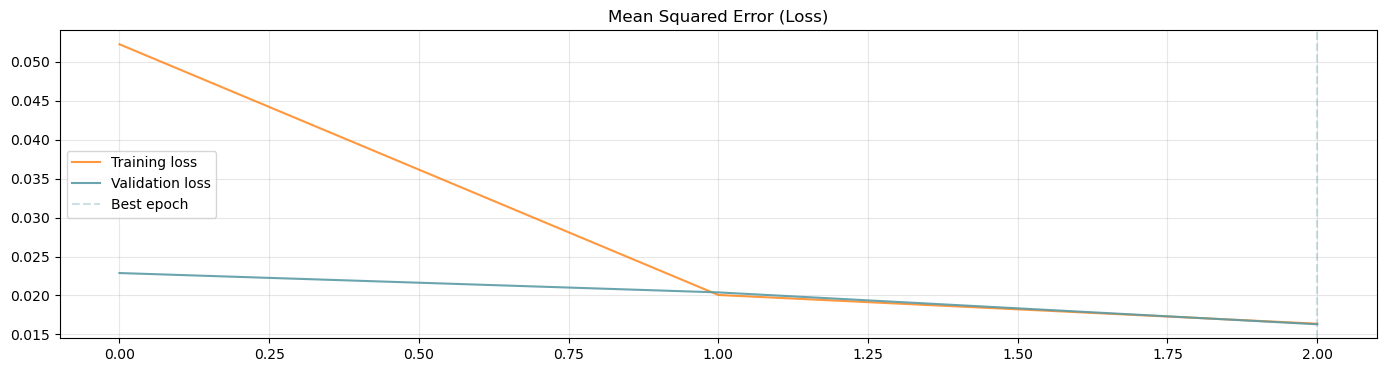

In [104]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

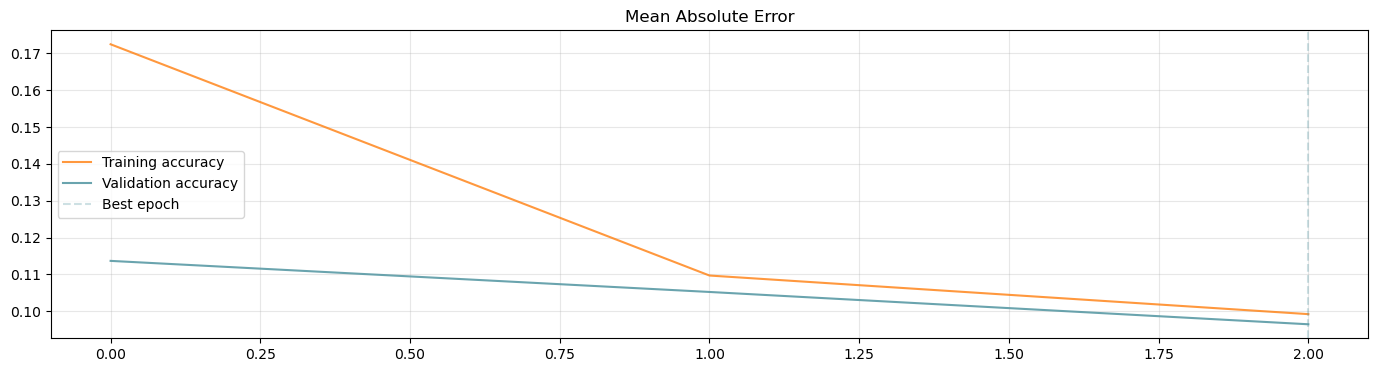

In [105]:
plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()